## Imports

In [1]:
import pandas as pd
import numpy as np
import re
from connection_keys import connection
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot
jtplot.style(theme='onedork', context='notebook', ticks=True, grid=False)

pd.set_option('display.max_colwidth', None)

from utils import transforma_campo_str_int

## Conecta com o banco e captura os dados

In [2]:
connectionbd = connection('db_hardware')
query = """
    select * from graphic_card
"""
df = pd.read_sql(query, connectionbd)

In [3]:
df.dtypes

id                      int64
marca                  object
nome_produto           object
preco_antigo_cartao    object
preco_atual_cartao     object
preco_boleto           object
data                   object
hora                   object
loja                   object
disponibilidade        object
dtype: object

In [4]:
df.sample(10)

,id,marca,nome_produto,preco_antigo_cartao,preco_atual_cartao,preco_boleto,data,hora,loja,disponibilidade
348,349,ASRock,"Placa de Video ASRock Phantom Gaming X AMD Radeon RX580 8G OC, GDDR5",0,"1.294,00","1.099,90",2020-09-10,19:12:39,Kabum,Indisponivel
6,7,Galax,"Placa de Vídeo Galax NVIDIA GeForce GT 710 1GB, DDR3 - 71GGF4DC00WG","315,68","294,63","279,90",2020-09-10,19:12:39,Kabum,Disponivel
295,296,Evga,"Placa de Vídeo EVGA NVIDIA GeForce GTX 1060 3GB SC Gaming, GDDR5 - 03G-P4-6162-KR","1.164,59","999,88","849,90",2020-09-10,19:12:39,Kabum,Indisponivel
343,344,Sapphire,"Placa de Vídeo Sapphire AMD Radeon RX 590, 8GB, GDDR5 - 11289-06-20G",0,"1.294,00","1.099,90",2020-09-10,19:12:39,Kabum,Indisponivel
1123,1124,Afox,"Placa de Vídeo Afox AMD Radeon RX560D, 4GB, GDDR5 - AFRX560D-4096D5H4-V3",0,"823,41","699,90",2020-09-13,13:04:07,Kabum,Indisponivel
188,189,XFX,"Placa de Vídeo XFX AMD Radeon RX 5700 XT Triple Dissipation, 8GB, GDDR6 - RX-57XT83LD8",0,"4.229,29","3.594,90",2020-09-10,19:12:39,Kabum,Disponivel
179,180,MSI,"Placa de Vídeo MSI AMD Radeon RX 5700 Gaming X, 8GB, GDDR6",0,"3.764,59","3.199,90",2020-09-10,19:12:39,Kabum,Disponivel
744,745,Evga,"Placa de Vídeo EVGA NVIDIA GeForce RTX 2060 Super SC Black Gaming, 8GB, GDDR6 - 08G-P4-3062-KR","4.646,94","3.637,53","3.091,90",2020-09-11,18:56:58,Kabum,Indisponivel
207,208,Pny,"Placa de Vídeo PNY NVIDIA Quadro NVS 810 4GB, DDR3 - VCNVS810DVI","5.947,90","5.623,41","4.779,90",2020-09-10,19:12:39,Kabum,Disponivel
691,692,MSI,"Placa de Vídeo MSI NVIDIA GeForce GTX 1060 IGamer 6G OC, GDDR5",0,"1.176,35","999,90",2020-09-11,18:56:58,Kabum,Indisponivel


In [5]:
# df.apply(lambda x: concatena_numero_apolice_seguradora(x['insurerCode'], x['insurerPolicyNumber']),axis=1)
df['preco_antigo_cartao'] = df['preco_antigo_cartao'].str.replace('.', '').str.replace(',', '.').astype(float)
df['preco_atual_cartao'] = df['preco_atual_cartao'].str.replace('.', '').str.replace(',', '.').astype(float)
df['preco_boleto'] = df['preco_boleto'].str.replace('.', '').str.replace(',', '.').astype(float)
df['nome_produto'] = df['nome_produto'].str.upper() 

In [6]:
df_marcas = df['preco_atual_cartao'].groupby(df['marca'])
print(df_marcas.mean())

marca
ASRock        2253.878974
Afox           403.817500
Amd           5921.450000
Aorus         9212.824000
Asus          3098.807579
Colorful      4827.015000
Deepcool       105.760000
Evga          3562.907337
Gainward      5177.025714
Galax         3338.299545
Gigabyte      2784.369535
Husky          823.410000
Liketec         23.410000
MSI           2599.921148
PCYes          525.448889
Pny           4035.938788
Powercolor    1700.960556
Rise Mode       36.468235
Sapphire      2241.206744
XFX           2049.386154
Zotac         2312.142800
Name: preco_atual_cartao, dtype: float64


In [7]:
df[df['marca'] == 'Asus']

,id,marca,nome_produto,preco_antigo_cartao,preco_atual_cartao,preco_boleto,data,hora,loja,disponibilidade
1,2,Asus,"PLACA DE VÍDEO ASUS TUF NVIDIA GEFORCE RTX 2060 6GB, GDDR6 - TUF-RTX2060-O6G-GAMING",2894.00,2658.71,2259.9,2020-09-10,19:12:39,Kabum,Disponivel
2,3,Asus,"PLACA DE VÍDEO ASUS TUF3 NVIDIA GEFORCE GTX 1660 SUPER 6GB, GDDR6 - TUF 3-GTX1660S-O6G-GAMING",2420.95,1894.63,1799.9,2020-09-10,19:12:39,Kabum,Disponivel
31,32,Asus,"PLACA DE VÍDEO ASUS TUF NVIDIA GEFORCE RTX 2060 6GB, GDDR6 - TUF-RTX2060-O6G-GAMING",2894.00,2658.71,2259.9,2020-09-10,19:12:39,Kabum,Disponivel
32,33,Asus,"PLACA DE VÍDEO ASUS TUF3 NVIDIA GEFORCE GTX 1660 SUPER 6GB, GDDR6 - TUF 3-GTX1660S-O6G-GAMING",2420.95,1894.63,1799.9,2020-09-10,19:12:39,Kabum,Disponivel
88,89,Asus,"PLACA DE VÍDEO ASUS NVIDIA DUAL GEFORCE RTX 2080 SUPER EVO V2 OC, 8GB, GDDR6 - DUAL-RTX2080S-O8G-EVO-V2",5882.24,5411.65,4599.9,2020-09-10,19:12:39,Kabum,Disponivel
...,...,...,...,...,...,...,...,...,...,...
1072,1073,Asus,"PLACA DE VÍDEO ASUS AMD RADEON RX 580 OC 8GB, GDDR5 - DUAL-RX580-O8G",0.00,1764.59,1499.9,2020-09-13,13:04:07,Kabum,Indisponivel
1117,1118,Asus,"PLACA DE VÍDEO ASUS TUF GAMING NVIDIA GEFORCE GTX 1650 SUPER OC, 4GB, GDDR6 - TUF-GTX1650S-O4G-GAMING",0.00,1646.94,1399.9,2020-09-13,13:04:07,Kabum,Indisponivel
1118,1119,Asus,"PLACA DE VÍDEO ASUS ROG STRIX AMD RX 5500 XT OC GAMING, 8G, GDDR6 - ROG-STRIX-RX5500XT-O8G-GAMING",0.00,2035.18,1729.9,2020-09-13,13:04:07,Kabum,Indisponivel
1125,1126,Asus,"PLACA DE VÍDEO ASUS TUF GAMING X3 AMD RADEON RX 5700 XT EVO, 8GB, GDDR6 - TUF 3-RX5700XT-O8G-EVO-GAMING",4705.76,3886.94,3303.9,2020-09-13,13:04:07,Kabum,Indisponivel


In [8]:
df.query('nome_produto.str.contains("GTX 1660") & (~nome_produto.str.contains("TI") & ~nome_produto.str.contains("SUPER"))')

,id,marca,nome_produto,preco_antigo_cartao,preco_atual_cartao,preco_boleto,data,hora,loja,disponibilidade
12,13,Gigabyte,"PLACA DE VÍDEO GIGABYTE NVIDIA GEFORCE GTX 1660 OC 6G, GDDR5 - GV-N1660OC-6GD",2157.79,2052.53,1949.9,2020-09-10,19:12:39,Kabum,Disponivel
42,43,Gigabyte,"PLACA DE VÍDEO GIGABYTE NVIDIA GEFORCE GTX 1660 OC 6G, GDDR5 - GV-N1660OC-6GD",2157.79,2052.53,1949.9,2020-09-10,19:12:39,Kabum,Disponivel
163,164,Evga,"PLACA DE VÍDEO EVGA NVIDIA GEFORCE GTX 1660 XC GAMING 6GB, GDDR5 - 06G-P4-1163-KR",2117.53,1941.06,1649.9,2020-09-10,19:12:39,Kabum,Disponivel
173,174,Zotac,"PLACA DE VÍDEO ZOTAC GAMING NVIDIA GEFORCE GTX 1660 TWIN FAN, 6GB, GDDR5 - ZT-T16600K-10M",0.00,2352.82,1999.9,2020-09-10,19:12:39,Kabum,Disponivel
329,330,Evga,"PLACA DE VÍDEO EVGA NVIDIA GEFORCE GTX 1660 XC BLACK GAMING 6GB, GDDR5 - 06G-P4-1161-KR",0.00,2082.24,1769.9,2020-09-10,19:12:39,Kabum,Indisponivel
330,331,Evga,"PLACA DE VÍDEO EVGA NVIDIA GEFORCE GTX 1660 XC ULTRA GAMING 6GB, GDDR5 - 06G-P4-1167-KR",0.00,1882.24,1599.9,2020-09-10,19:12:39,Kabum,Indisponivel
332,333,Galax,"PLACA DE VÍDEO GALAX NVIDIA GEFORCE GTX 1660 1-CLICK OC, 6GB, GDDR5 - 60SRH7DSY91C",2235.18,2199.88,1869.9,2020-09-10,19:12:39,Kabum,Indisponivel
336,337,Evga,"PLACA DE VÍDEO EVGA NVIDIA GEFORCE GTX 1660 SC ULTRA GAMING 6GB, GDDR5 - 06G-P4-1067-KR",2235.18,2011.65,1709.9,2020-09-10,19:12:39,Kabum,Indisponivel
373,374,Evga,"PLACA DE VÍDEO EVGA NVIDIA GEFORCE GTX 1660 BLACK GAMING, 6GB, GDDR5 - 06G-P4-1160-KR",2352.82,2117.53,1799.9,2020-09-10,19:12:39,Kabum,Indisponivel
400,401,Gigabyte,"PLACA DE VÍDEO GIGABYTE NVIDIA GEFORCE GTX 1660 OC 6G, GDDR5 - GV-N1660OC-6GD",2157.79,2052.53,1949.9,2020-09-11,18:56:58,Kabum,Disponivel


In [9]:
def get_resume_product_name(name):
    # string = df['nome_produto'][df['id'] == 259].item()
    pattern = "(RTX|GTX|GT|RX|WX|Quadro|R7|R5|R9|HD)(\d+)"
    resume_name = re.search(pattern, name.replace(" ", ""))
    if resume_name is None: 
        return '' 
    else: 
        return resume_name.group()

df['nome_produto_resumido'] = df.apply(lambda x: get_resume_product_name(x['nome_produto']), axis=1)

In [12]:
len(df.query('nome_produto_resumido == ""').index)

0

In [11]:
indexNames = df[df['nome_produto_resumido'] == '' ].index
df.drop(indexNames , inplace=True)

In [16]:
placa = 'GTX 1660'
analise = df.query(f'nome_produto.str.contains("{placa}") & (~nome_produto.str.contains("TI") & ~nome_produto.str.contains("SUPER"))')
(analise['preco_atual_cartao'].groupby(analise['marca']).mean())
analise

,id,marca,nome_produto,preco_antigo_cartao,preco_atual_cartao,preco_boleto,data,hora,loja,disponibilidade,nome_produto_resumido
12,13,Gigabyte,"PLACA DE VÍDEO GIGABYTE NVIDIA GEFORCE GTX 1660 OC 6G, GDDR5 - GV-N1660OC-6GD",2157.79,2052.53,1949.9,2020-09-10,19:12:39,Kabum,Disponivel,GTX1660
42,43,Gigabyte,"PLACA DE VÍDEO GIGABYTE NVIDIA GEFORCE GTX 1660 OC 6G, GDDR5 - GV-N1660OC-6GD",2157.79,2052.53,1949.9,2020-09-10,19:12:39,Kabum,Disponivel,GTX1660
163,164,Evga,"PLACA DE VÍDEO EVGA NVIDIA GEFORCE GTX 1660 XC GAMING 6GB, GDDR5 - 06G-P4-1163-KR",2117.53,1941.06,1649.9,2020-09-10,19:12:39,Kabum,Disponivel,GTX1660
173,174,Zotac,"PLACA DE VÍDEO ZOTAC GAMING NVIDIA GEFORCE GTX 1660 TWIN FAN, 6GB, GDDR5 - ZT-T16600K-10M",0.00,2352.82,1999.9,2020-09-10,19:12:39,Kabum,Disponivel,GTX1660
329,330,Evga,"PLACA DE VÍDEO EVGA NVIDIA GEFORCE GTX 1660 XC BLACK GAMING 6GB, GDDR5 - 06G-P4-1161-KR",0.00,2082.24,1769.9,2020-09-10,19:12:39,Kabum,Indisponivel,GTX1660
330,331,Evga,"PLACA DE VÍDEO EVGA NVIDIA GEFORCE GTX 1660 XC ULTRA GAMING 6GB, GDDR5 - 06G-P4-1167-KR",0.00,1882.24,1599.9,2020-09-10,19:12:39,Kabum,Indisponivel,GTX1660
332,333,Galax,"PLACA DE VÍDEO GALAX NVIDIA GEFORCE GTX 1660 1-CLICK OC, 6GB, GDDR5 - 60SRH7DSY91C",2235.18,2199.88,1869.9,2020-09-10,19:12:39,Kabum,Indisponivel,GTX16601
336,337,Evga,"PLACA DE VÍDEO EVGA NVIDIA GEFORCE GTX 1660 SC ULTRA GAMING 6GB, GDDR5 - 06G-P4-1067-KR",2235.18,2011.65,1709.9,2020-09-10,19:12:39,Kabum,Indisponivel,GTX1660
373,374,Evga,"PLACA DE VÍDEO EVGA NVIDIA GEFORCE GTX 1660 BLACK GAMING, 6GB, GDDR5 - 06G-P4-1160-KR",2352.82,2117.53,1799.9,2020-09-10,19:12:39,Kabum,Indisponivel,GTX1660
400,401,Gigabyte,"PLACA DE VÍDEO GIGABYTE NVIDIA GEFORCE GTX 1660 OC 6G, GDDR5 - GV-N1660OC-6GD",2157.79,2052.53,1949.9,2020-09-11,18:56:58,Kabum,Disponivel,GTX1660


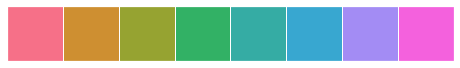

In [21]:
sns.palplot(sns.color_palette("husl", 8))
# sns.color_palette("rocket", as_cmap=True)

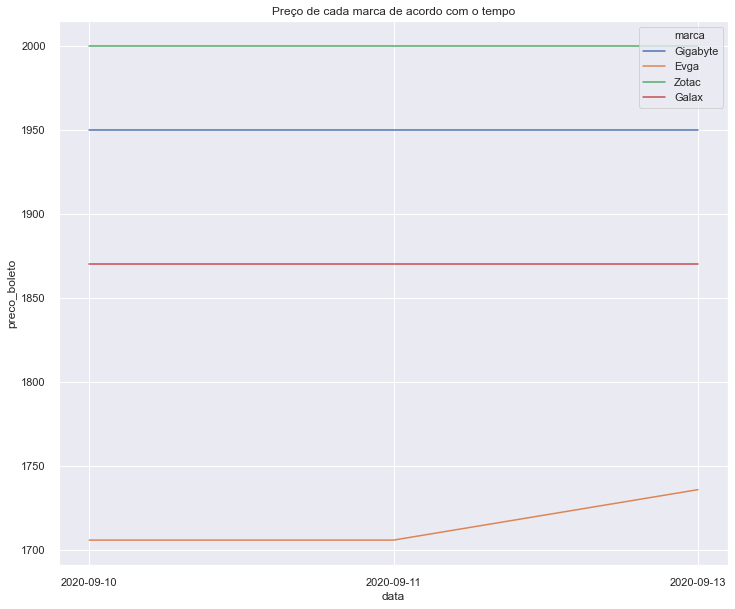

In [17]:
# plt.figure(figsize=(30,19))
sns.set(rc={'figure.figsize':(12,10)})
ax = sns.lineplot(
    x="data",
    y="preco_boleto",
    hue='marca',
    data=analise,
    ci=None,
    markers=True
).set_title('Preço de cada marca de acordo com o tempo');